# Machine Learning Foundations
## Assignment 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import ADASYN
from boruta import BorutaPy

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


## Task 1: Data Loading and Initial Exploration

In [2]:
df = pd.read_excel("titanic3.xls")
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


At first look, it might be best to exclude boat and body because of leakage. Only the people that survived have a boat number assigned which can lead to a misleading model. Moreover, only the bodies of the people that didnt survive and were recovered have a body number.

In [3]:
df.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


I also looked at correlation plots to try to identify patterns. Survival has non-linear relationships with the features.

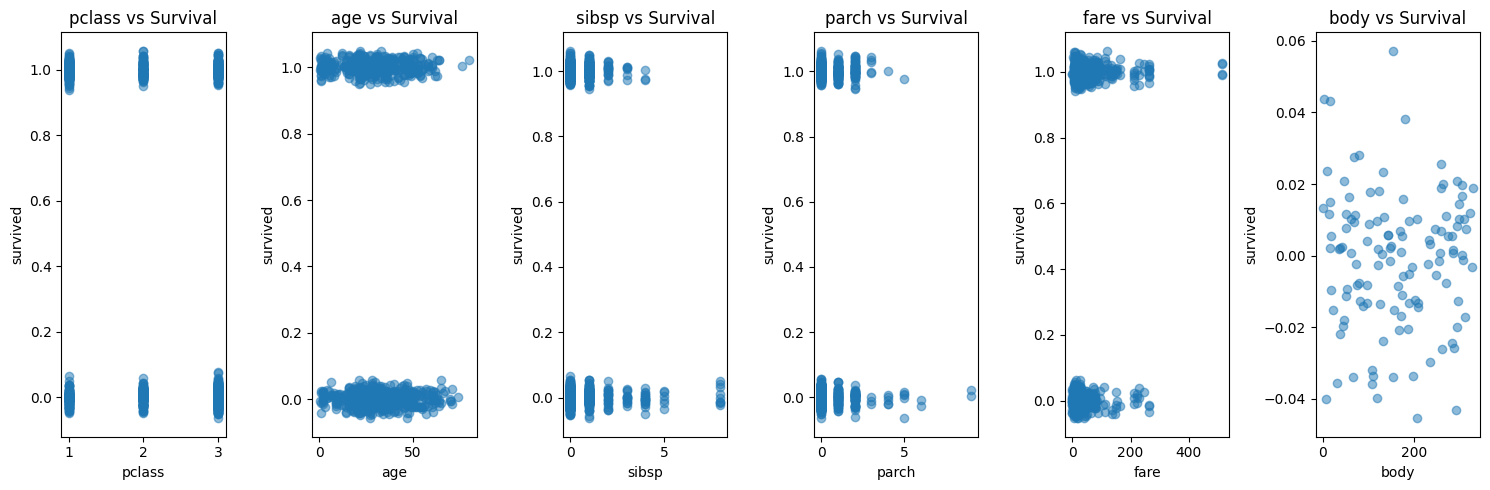

In [4]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
numeric_cols = [col for col in numeric_cols if col != 'survived']

plt.figure(figsize=(15, 5))

for i, feature in enumerate(numeric_cols, 1):
    plt.subplot(1, len(numeric_cols), i)
    jitter = np.random.normal(0, 0.02, size=len(df))
    plt.scatter(df[feature], df['survived'] + jitter, alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('survived')
    plt.title(f'{feature} vs Survival')

plt.tight_layout()
plt.show()

## Task 2: Managing Missing Values

In [5]:
df.info()
df.isnull().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


body         1188
cabin        1014
boat          823
home.dest     564
age           263
embarked        2
fare            1
pclass          0
survived        0
name            0
sex             0
sibsp           0
parch           0
ticket          0
dtype: int64

I started by checking for possible sparse within classes (the ones with a lot of missing data)
In our case, body, cabin, boat, home destination, and age might cause issues.

Here is how i dealt with the missing values:


### Age missing values

My first step is addressing the age missing values since its an important factor for survival prediction. 

Based on the plots, I ended up replacing the missing values by the mean. The distribution by gender is different so i made sure to have different means for different gender.

sex
female    28.687071
male      30.585233
Name: age, dtype: float64 sex
female    27.0
male      28.0
Name: age, dtype: float64


<Axes: xlabel='age', ylabel='Count'>

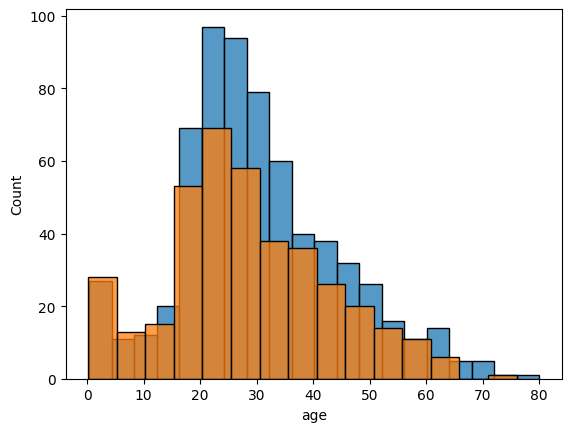

In [6]:
print(df.groupby(['sex'])['age'].mean(), df.groupby(['sex'])['age'].median())

males = df.loc[df['sex'] == 'male']

females = df.loc[df['sex'] == 'female']
sns.histplot(males['age'])
sns.histplot(females['age'])


In [7]:
mean = df.groupby(['sex'])['age'].mean()
df['age'] = df.groupby(['sex'])['age'].transform(
    lambda x: x.fillna(x.mean())
)

df.isnull().sum().sort_values(ascending=False)


body         1188
cabin        1014
boat          823
home.dest     564
embarked        2
fare            1
pclass          0
survived        0
name            0
sex             0
age             0
sibsp           0
parch           0
ticket          0
dtype: int64

### Embarked missing values

i dealt with the missing values in embarked by replacing them with the most repeated value.

In [8]:
df['embarked'] = df['embarked'].fillna(df['embarked'].mode()[0])
print(df['embarked'].value_counts())
df.isnull().sum().sort_values(ascending=False)


embarked
S    916
C    270
Q    123
Name: count, dtype: int64


body         1188
cabin        1014
boat          823
home.dest     564
fare            1
pclass          0
survived        0
name            0
sex             0
age             0
sibsp           0
parch           0
ticket          0
embarked        0
dtype: int64

### Fare missing values

To deal with the fare, i compared the mean and the median. looking at the skewed distribution, the mean seems more appropriate.

14.4542 33.29547928134557


<Axes: xlabel='fare', ylabel='Count'>

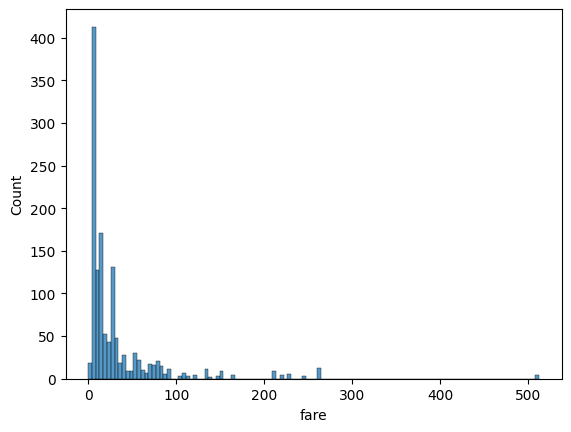

In [9]:
print(df['fare'].median(), df['fare'].mean())

df.loc[df['fare'].isnull()]

sns.histplot(df['fare'])


In [10]:
df['fare'] = df['fare'].fillna(df['fare'].mean())

df.isnull().sum().sort_values(ascending=False)


body         1188
cabin        1014
boat          823
home.dest     564
pclass          0
survived        0
name            0
sex             0
age             0
sibsp           0
parch           0
ticket          0
fare            0
embarked        0
dtype: int64

### Boat and Body missing values

My next step was to drop the body and boat columns because they could cause data leakage.

In [11]:
df.drop(columns = ['body', 'boat'], inplace=True)
df.isnull().sum().sort_values(ascending=False)

cabin        1014
home.dest     564
pclass          0
survived        0
name            0
sex             0
age             0
sibsp           0
parch           0
ticket          0
fare            0
embarked        0
dtype: int64

### Home.dest missing values

I replaced the missing values of home.dest by 'U' for unknown. (however, I might drop the column later on)

In [12]:
df['home.dest']= df['home.dest'].fillna('U')
df.isnull().sum().sort_values(ascending=False)

cabin        1014
pclass          0
survived        0
name            0
sex             0
age             0
sibsp           0
parch           0
ticket          0
fare            0
embarked        0
home.dest       0
dtype: int64

### Cabin missing values

Finally, I had to find a way to deal with the cabin class. I decided to create a new category to store only the letter. This will simplify the feature since the letter is more meaningful than the number. The missing values will be replaced by 'U' for unknown.

In [13]:
df['deck'] = df['cabin'].apply(lambda x: str(x)[0] if pd.notnull(x) else 'U')

df.drop('cabin', axis=1, inplace = True)

print(df['deck'].value_counts())
df.isnull().sum().sort_values(ascending=False)


deck
U    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: count, dtype: int64


pclass       0
survived     0
name         0
sex          0
age          0
sibsp        0
parch        0
ticket       0
fare         0
embarked     0
home.dest    0
deck         0
dtype: int64

## Task 3: Encoding Categorical Variables

In [14]:
df.head()


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,embarked,home.dest,deck
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,S,"St Louis, MO",B
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,S,"Montreal, PQ / Chesterville, ON",C
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,S,"Montreal, PQ / Chesterville, ON",C
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,S,"Montreal, PQ / Chesterville, ON",C
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,S,"Montreal, PQ / Chesterville, ON",C


We can see that the categorical variables are name, sex, ticket, embarked, home.dest and deck.

### Name and Home.dest encoding

We cant use name nor home.dest because encoding increases the dimensionality and sparsity. I dropped the columns

In [15]:
df.drop(columns = ['name', 'home.dest'], inplace = True)

df.head()

,pclass,survived,sex,age,sibsp,parch,ticket,fare,embarked,deck
0,1,1,female,29.0000,0,0,24160,211.3375,S,B
1,1,1,male,0.9167,1,2,113781,151.5500,S,C
2,1,0,female,2.0000,1,2,113781,151.5500,S,C
3,1,0,male,30.0000,1,2,113781,151.5500,S,C
4,1,0,female,25.0000,1,2,113781,151.5500,S,C


### Sex, Embarked and Deck encoding

First, im encoding sex, embarked and deck using one-hot encoding.

In [16]:
encoder = OneHotEncoder(sparse_output=False)
categorical_features = ['sex', 'embarked', 'deck']
encoded_features = encoder.fit_transform(df[categorical_features])
feature_names = encoder.get_feature_names_out(categorical_features)
encoded_df = pd.DataFrame(encoded_features, columns=feature_names, index=df.index)
df = pd.concat([df, encoded_df], axis=1)
df.drop(columns=categorical_features, inplace=True)
df.head()

,pclass,survived,age,sibsp,parch,ticket,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T,deck_U
0,1,1,29.0000,0,0,24160,211.3375,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,0.9167,1,2,113781,151.5500,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,2.0000,1,2,113781,151.5500,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,30.0000,1,2,113781,151.5500,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,25.0000,1,2,113781,151.5500,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


##### sex encoding:

before: 2 categories (male, female)

after : sex_female, sex_male

I created binary columns that are perfectly collinear. However, one could be derived from the other so we could drop a column in the next steps.


##### embarked encoding:

before: 3 categories (S,C,Q)

after: embarked_S, embarked_C, embarked_Q
I created 3 binary columns. However, I could also drop one column as its redundant.


##### deck encoding:

before: 9 categories (A,B,C,D,E,F,G,U)

after: one column per deck

I created many sparse columns due to 'U' being dominant (1014 out of 1309 entries). This caused high dimensionality so I might need to do feature selection in the next steps.

#### Ticket encoding

I tried to find a use for the ticket category. I first assumed that it was similar to the family features sibsp and parch. However, friends couldve been included in the same ticket so I ended up creating ticket_group_size to have some insight about the size of the group travelling together.

We can see in the graph below that bigger groups had a better chance of survival. However, groups that were too big were also disadvantaged.

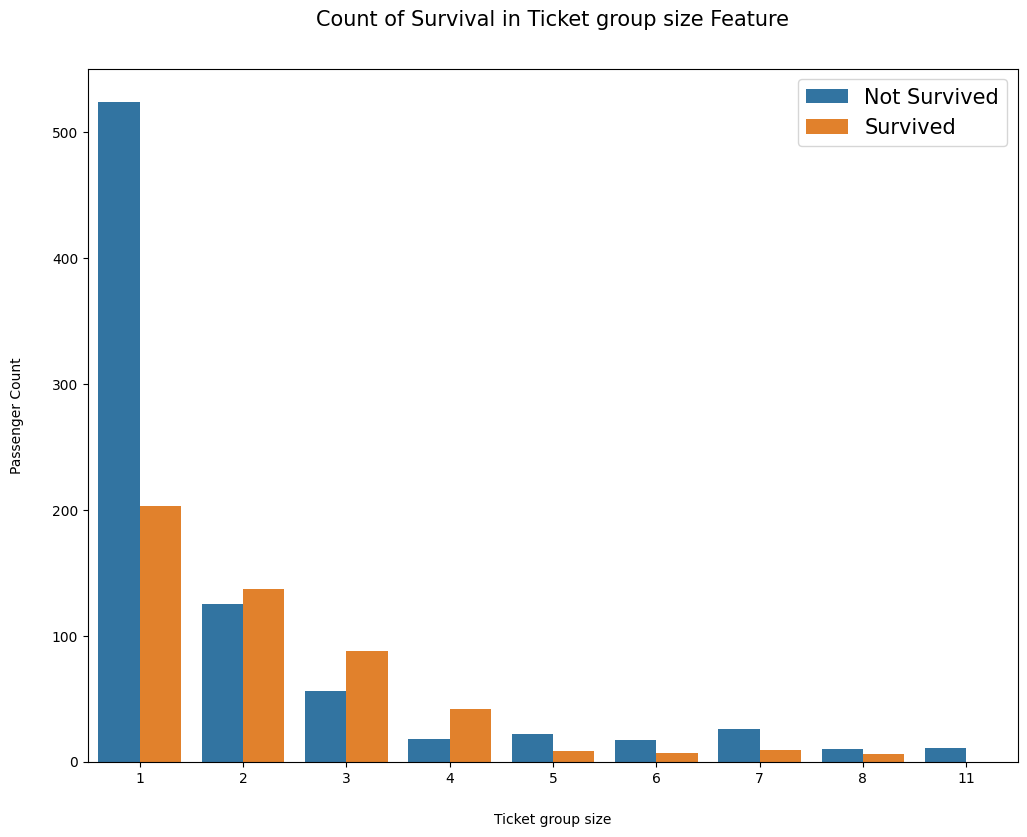

In [17]:
df['ticket_group_size'] = df.groupby('ticket')['ticket'].transform('count')

fig, axs = plt.subplots(figsize=(12, 9))
sns.countplot(x='ticket_group_size', hue='survived', data=df)

plt.xlabel('Ticket group size', size=10, labelpad=20)
plt.ylabel('Passenger Count', size=10, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in Ticket group size Feature', size=15, y=1.05)

plt.show()

In [18]:
print(df['ticket_group_size'].value_counts().sort_index())

df.drop('ticket', axis=1, inplace=True)
df.head()


ticket_group_size
1     727
2     262
3     144
4      60
5      30
6      24
7      35
8      16
11     11
Name: count, dtype: int64


,pclass,survived,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T,deck_U,ticket_group_size
0,1,1,29.0000,0,0,211.3375,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,1,1,0.9167,1,2,151.5500,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6
2,1,0,2.0000,1,2,151.5500,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6
3,1,0,30.0000,1,2,151.5500,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6
4,1,0,25.0000,1,2,151.5500,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6


Only very few ML algorithms support categorical attributes, this is why encoding is crucial.

In my case, each category recieved equal weights. The binary features are now easily interpretable which will improve the ML algorithm's performance. 

## Task 4: Feature Scaling

Normalization: scales features to a predefined range of values ( ex:  [0,1] ). it is more sensitive to outliers but better for bounded data.

Standardization: centers data around 0 with std = 1. the feature values have the properties of a standard normal distribution. It is more robust to outliers and better for unbounded data.

Feature scaling is important because it prevents features with larger numerical ranges from dominating the model's learning process. It makes sure that all the features contribute proportionally to the predictions.

Based on the histograms, pclass, sibsp, parch and ticket_group_size all contain discrete values so should be normalized.

On the other hand, age and fare are continuous, they should be standarized.

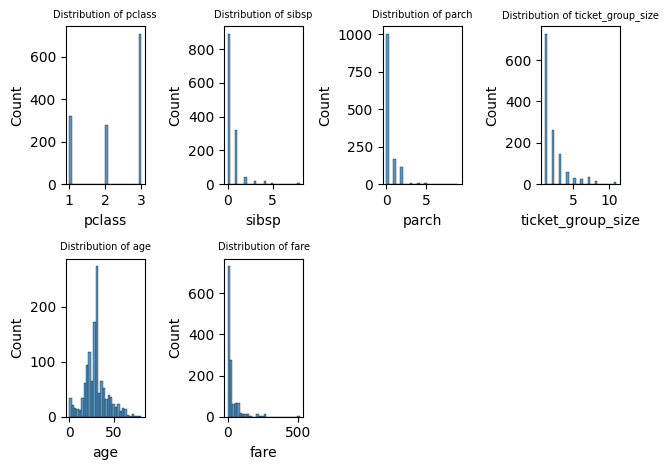

In [19]:
numeric_cols = ['pclass', 'sibsp', 'parch', 'ticket_group_size', 'age', 'fare']

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 4, i)
    sns.histplot(data=df, x=col, bins=30)
    plt.title(f'Distribution of {col}', fontsize=7)
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [20]:
normalizer = MinMaxScaler()
normalize_cols = ['pclass', 'sibsp', 'parch', 'ticket_group_size']
df[normalize_cols] = normalizer.fit_transform(df[normalize_cols])

standardizer = StandardScaler()
standardize_cols = ['age', 'fare']
df[standardize_cols] = standardizer.fit_transform(df[standardize_cols])

df.head()

,pclass,survived,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T,deck_U,ticket_group_size
0,0.0,1,-0.070589,0.000,0.000000,3.442480,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1,-2.250248,0.125,0.222222,2.286476,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
2,0.0,0,-2.166169,0.125,0.222222,2.286476,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
3,0.0,0,0.007025,0.125,0.222222,2.286476,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
4,0.0,0,-0.381046,0.125,0.222222,2.286476,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5


## Task 5: Data Splitting

To efficiently split the data, I first made sure to separate the features (X) and target variable (Y).

In [21]:
X = df.drop('survived', axis=1)
y = df['survived']

Next, I separated my training set from the rest (60-40 since its a small dataset).

I also used stratification to maintain the same proportion of survival outcomes in all sets.

In [22]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, 
    y,
    test_size=0.4,
    random_state=42,  
    stratify=y # proportion of survived and not survived is the same in all sets
)

In the same way, I split the remaining data for test and validation equally.

In [23]:
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

Finally, I verified the target distribution in each set. The split reflects the original distribution of the target variable. (might have to check dist of each category in the 3 sets)

In [24]:
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))

print("original:", y.value_counts(normalize=True))
print("training:", y_train.value_counts(normalize=True))
print("validation:", y_val.value_counts(normalize=True))
print("test:", y_test.value_counts(normalize=True))

X_train shape: (785, 20)
y_train shape: (785,)
X_test shape: (262, 20)
original: survived
0    0.618029
1    0.381971
Name: proportion, dtype: float64
training: survived
0    0.617834
1    0.382166
Name: proportion, dtype: float64
validation: survived
0    0.618321
1    0.381679
Name: proportion, dtype: float64
test: survived
0    0.618321
1    0.381679
Name: proportion, dtype: float64


UPDATE: I went back to look at boxplots and identify outliers to improve the model's performance. I made sure to do it after splitting the data but before balancing the classes. 

I ended up getting rid of 'fare' outliers, it proved to be successful.

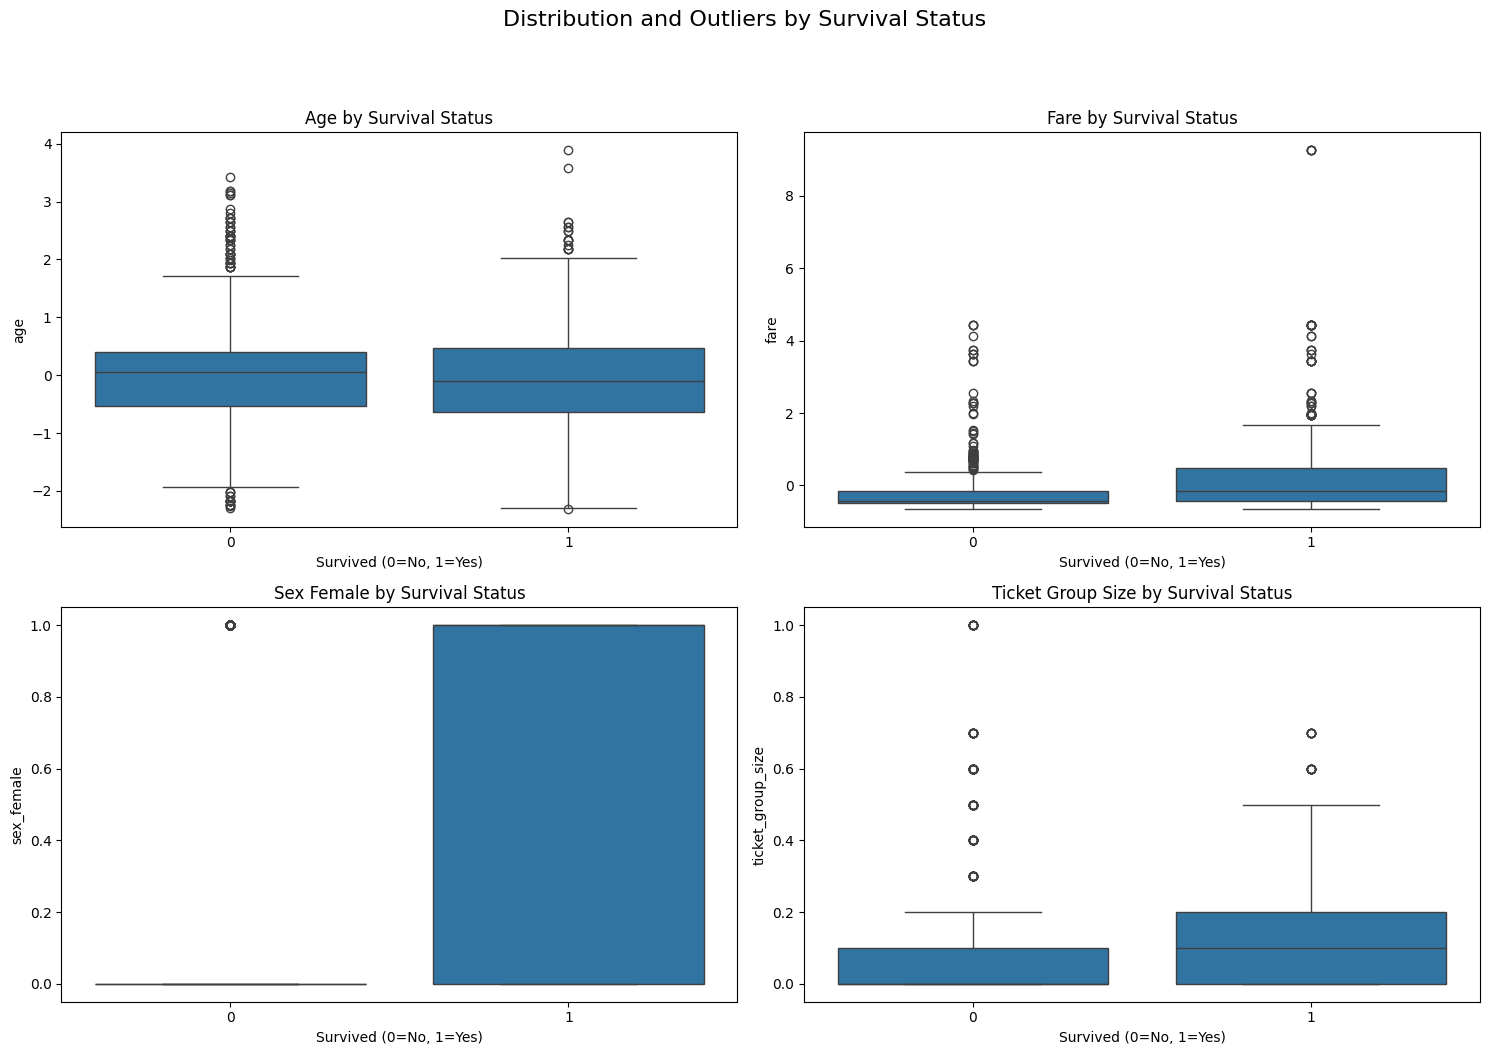

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distribution and Outliers by Survival Status', fontsize=16, y=1.05)

sns.boxplot(x='survived', y='age', data=df, ax=axes[0,0])
axes[0,0].set_title('Age by Survival Status')
axes[0,0].set_xlabel('Survived (0=No, 1=Yes)')

sns.boxplot(x='survived', y='fare', data=df, ax=axes[0,1])
axes[0,1].set_title('Fare by Survival Status')
axes[0,1].set_xlabel('Survived (0=No, 1=Yes)')

sns.boxplot(x='survived', y='sex_female', data=df, ax=axes[1,0])
axes[1,0].set_title('Sex Female by Survival Status')
axes[1,0].set_xlabel('Survived (0=No, 1=Yes)')

sns.boxplot(x='survived', y='ticket_group_size', data=df, ax=axes[1,1])
axes[1,1].set_title('Ticket Group Size by Survival Status')
axes[1,1].set_xlabel('Survived (0=No, 1=Yes)')

plt.tight_layout()
plt.show()

In [26]:
Q1 = X_train['fare'].quantile(0.25)
Q3 = X_train['fare'].quantile(0.75)
IQR = Q3 - Q1
X_train['fare'] = X_train['fare'].clip(
    lower=Q1 - 1.5*IQR,
    upper=Q3 + 1.5*IQR
)

## Task 6: Addressing Class Imbalance

Class imbalance is the problem of very uneven distributions of labels in the training data. This can significantly affect the performance of the model no matter what learning algorithm we chose. This is why we need to make sure that we have similar numbers of survived vs not survived.

Based on the target distribution in each set, we have more not survived than survived ( 60-40 ). however, we can use a sampling technique to reach 50-50.

We must choose oversampling over undersampling since our dataset is small.

By implementing ADASYN we are creating synthetic examples for the minority class. Those examples are in regions where minority class samples are harder to classify (close to the majority class samples).






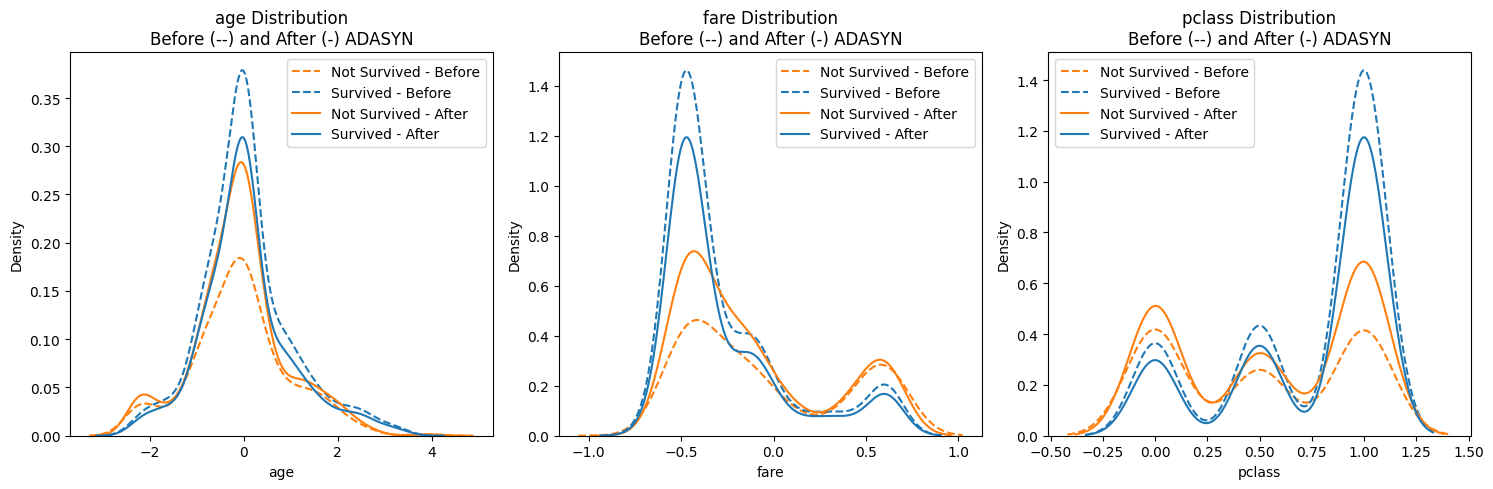

before ADASYN: survived
0    0.617834
1    0.382166
Name: proportion, dtype: float64
after ADASYN: survived
0    0.504683
1    0.495317
Name: proportion, dtype: float64


In [27]:
ada = ADASYN(random_state=42)
X_train_balanced, y_train_balanced = ada.fit_resample(X_train, y_train)

features_to_plot = ['age', 'fare', 'pclass']
fig, axes = plt.subplots(1, len(features_to_plot), figsize=(15, 5))

for i, feature in enumerate(features_to_plot):
    sns.kdeplot(data=X_train, x=feature, hue=y_train, 
                ax=axes[i], linestyle='--', label=['Not Survived', 'Survived'])
    
    sns.kdeplot(data=X_train_balanced, x=feature, hue=y_train_balanced, 
                ax=axes[i], linestyle='-')
    
    axes[i].set_title(f'{feature} Distribution\nBefore (--) and After (-) ADASYN')
    axes[i].legend(['Not Survived - Before', 'Survived - Before',
                   'Not Survived - After', 'Survived - After'])

plt.tight_layout()
plt.show()


print("before ADASYN:", y_train.value_counts(normalize=True))
print("after ADASYN:", y_train_balanced.value_counts(normalize=True))




We can see that ADASYN successfully balanced the classes while preserving the patterns in the data. The original distributions were maintained.

## Task 7: Feature Selection

Not all features are equally relevant. My first step was to look at low variance and highly correlated features

In [28]:
df.head()

,pclass,survived,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T,deck_U,ticket_group_size
0,0.0,1,-0.070589,0.000,0.000000,3.442480,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1,-2.250248,0.125,0.222222,2.286476,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
2,0.0,0,-2.166169,0.125,0.222222,2.286476,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
3,0.0,0,0.007025,0.125,0.222222,2.286476,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
4,0.0,0,-0.381046,0.125,0.222222,2.286476,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5


In [29]:
selector = VarianceThreshold(threshold=0.01)
selector.fit(X_train_balanced)
low_variance_features = X_train_balanced.columns[~selector.get_support()].tolist()

print("Low variance features:")
for feature in low_variance_features:
    print(f"- {feature} (variance: {X_train_balanced[feature].var():.4f})")

correlation_matrix = X_train_balanced.corr()
high_correlation_pairs = []
correlation_threshold = 0.8

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            high_correlation_pairs.append(
                (correlation_matrix.columns[i], 
                 correlation_matrix.columns[j], 
                 correlation_matrix.iloc[i, j])
            )

print("\nHighly correlated feature pairs:")
for feat1, feat2, corr in high_correlation_pairs:
    print(f"- {feat1} & {feat2}: {corr:.4f}")

Low variance features:
- parch (variance: 0.0090)
- deck_F (variance: 0.0062)
- deck_G (variance: 0.0036)
- deck_T (variance: 0.0010)

Highly correlated feature pairs:
- sex_male & sex_female: -1.0000


In addition, implementing Boruta might be more beneficial to have a better understanding of the important features. It could be more reliable than the single-pass feature selection done above.

(Survival has non-linear relationships with the features)

In [30]:
rf = RandomForestClassifier(n_jobs=-1, random_state=42) # random forest is the base estimator

boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)

boruta.fit(X_train_balanced.values, y_train_balanced)

selected_features = X_train_balanced.columns[boruta.support_]
    
feature_ranks = pd.DataFrame({
    'Feature': X_train_balanced.columns,
    'Rank': boruta.ranking_,
    'Important': boruta.support_
})

feature_ranks.sort_values('Rank')

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	2
Tentative: 	2
Rejected: 	16
Iteration: 	9 / 100
Confirmed: 	2
Tentative: 	2
Rejected: 	16
Iteration: 	10 / 100
Confirmed: 	2
Tentative: 	2
Rejected: 	16
Iteration: 	11 / 100
Confirmed: 	2
Tentative: 	2
Rejected: 	16
Iteration: 	12 / 100
Confirmed: 	2
Tentative: 	2
Rejected: 	16
Iteration: 	13 / 100
Confirmed: 	2
Tentative: 	2
Rejected: 	16
Iteration: 	14 / 100
Confirmed: 	2
Tentative: 	2
Rejected: 	16
Iteration: 	15 / 100
Confirmed: 	2
Tentative: 	2
Rejected: 	16
Iteration: 	16 / 100
Confirmed: 	2
Tentative: 	2
Rejected: 	16
I

,Feature,Rank,Important
1,age,1,True
4,fare,1,True
5,sex_female,1,True
6,sex_male,2,False
19,ticket_group_size,3,False
2,sibsp,4,False
0,pclass,5,False
3,parch,6,False
18,deck_U,7,False
9,embarked_S,8,False


Looking at the Boruta results:

Age is the strongest predictor of survival. This could be because children go first in this kind of situations.

Sex_female came in second, this could be because they have the priority in this case as well. (sex_male is redundant as they are perfectly collinear).

Fare also significantly influenced survival rates. it might be a better socioeconomic indicator than class alone.

Family features such as sibsp parch and ticket_group_size arent marked as important. this could mean that family size wasnt a primar survival factor.
UPDATE: after testing the model, i decided to include ticket_group_size

Location features such as embarked_ and deck_ ranked lowest which could mean that placement had minimal impact on survival. 

In [31]:
selected_features = ['age', 'sex_female', 'fare', 'ticket_group_size']
X_train_selected = X_train_balanced[selected_features]
print(selected_features)

['age', 'sex_female', 'fare', 'ticket_group_size']


The main reason why we addressed class imbalance and feature selection after splitting the dataset is to prevent data leakage.

If we applied ADASYN before splitting, synthetic samples would leak into test/validation sets. Therefore, the test set wouldnt represent real-world data distribution.


If we applied Boruta before splitting, the different importances of the features would be influenced by the test data which can lead to selection bias.

(We must always remember that all the transformations should be learned from the training data only)

## Task 8: Training a Logistic Regression Model

In [32]:
X_train_selected.shape
y_train_balanced.shape

(961,)

In [33]:
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_selected, y_train_balanced)

y_pred = lr_model.predict(X_val[selected_features])
y_pred_proba = lr_model.predict_proba(X_val[selected_features])


After experiemnting for a while with my model, i went back and made some additional changes (such as removing fare outliers and adding more selected features). Although the series of decisions I had to make lead to some trade-offs, I believe I ended up with a more reliable and consistent model.

Here are the final analytics of the model's performance:

Text(158.22222222222223, 0.5, 'Actual')

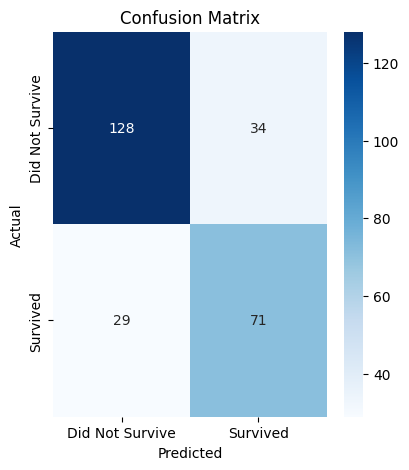

In [34]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Did Not Survive', 'Survived'],
            yticklabels=['Did Not Survive', 'Survived'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [35]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.79      0.80       162
           1       0.68      0.71      0.69       100

    accuracy                           0.76       262
   macro avg       0.75      0.75      0.75       262
weighted avg       0.76      0.76      0.76       262



Looking at the confusion matrix, we can get a good idea on the model's performance.

TN: 128

FP: 34

FN: 29

TP: 71

We can determine key metrics:

accuracy = TP+TN/total = 76% -> the model correctly predicted 76% of the 262 cases. this shows good predictive power.

recall = TP/TP+FN = 71% -> out of all the survivors the model predicted 71% corretly.

precision = TP/TP+FP = 68% -> out of the predicted survivors 68% actually survived

We can conclude that the model is slightly better at predicting deaths than survivals. 

UPDATE: 
precision-recall trade-off: 

After experimenting with my model, I decided to prioritize recall. this is because missing a survivor could mean failing to allocate life-saving resources. Its better to be over-prepared and have extra resources ready than miss someone who might needs help.


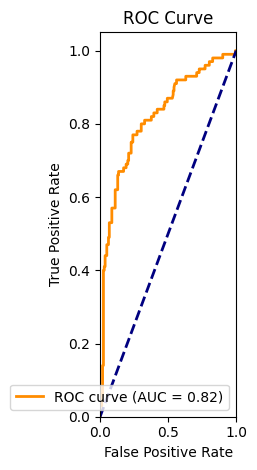

In [36]:
plt.subplot(133)
fpr, tpr, _ = roc_curve(y_val, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

Looking at the ROC curve for the validation, here are some key take-outs:

AUC of 0.82 indicates good model performance. the model is then 82% better than random chance.

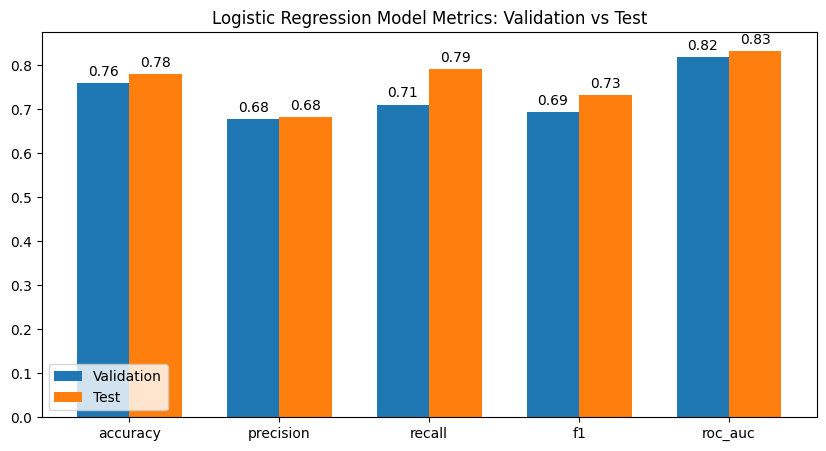

In [37]:
# making predictions on the test set
y_test_pred = lr_model.predict(X_test[selected_features])
y_test_pred_proba = lr_model.predict_proba(X_test[selected_features])

val_metrics = {
    "accuracy": accuracy_score(y_val, y_pred),
    "precision": precision_score(y_val, y_pred),
    "recall": recall_score(y_val, y_pred),
    "f1": f1_score(y_val, y_pred),
    "roc_auc": roc_auc_score(y_val, y_pred_proba[:, 1])
}

test_metrics = {
    "accuracy": accuracy_score(y_test, y_test_pred),
    "precision": precision_score(y_test, y_test_pred),
    "recall": recall_score(y_test, y_test_pred),
    "f1": f1_score(y_test, y_test_pred),
    "roc_auc": roc_auc_score(y_test, y_test_pred_proba[:, 1])
}

metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
val_values = [val_metrics[metric] for metric in metrics]
test_values = [test_metrics[metric] for metric in metrics]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x - width/2, val_values, width, label='Validation')
rects2 = ax.bar(x + width/2, test_values, width, label='Test')

ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_title("Logistic Regression Model Metrics: Validation vs Test")
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

In [38]:
cv_scores = cross_val_score(lr_model, X_train_selected, y_train_balanced, cv=5) # rule of thumb is 5 folds

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

Cross-validation scores: [0.76165803 0.75       0.70833333 0.67708333 0.60416667]
Mean CV Score: 0.700 (+/- 0.113)


The visualisation of the logistic regression model shows that the model's performance is consistent across validation and test sets which means good generalization. However, the cross-validation results show that its performance varies across different data splits. Our model performance could be more sensitive to the specific data spilts used.

## Conclusion

The model achieves reasonable predictive performance. It has achieved an accuracy of .76 and an AUC of .82 which highlight the functional predictive power of the model.  However, cross-validation revealed areas for potential improvement in model stability and generalization.